In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
import numpy as np
import csv
import time
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import f1_score
from pathlib import Path

## 💡 Reasoning for choosing a model 

📝 Convolutional Neural Networks (CNNs) are designed to work with spatial structures, where local patterns matter. In Tetris:
* The game board is a matrix (20×10).
* Each cell is either empty or filled (encoded as 0/1).
* Blocks fall and form local patterns that influence the next move.
* CNNs can capture these local spatial patterns:
* Filters  slide over small areas of the board.
* CNN learns to detect holes, gaps, potential lines to clear, or spaces where a piece fits.
* Effectively, the board is treated like an image, and the CNN predicts the best move based on patterns in that image.

## 🧮 Mathematical view of CNN for Tetris

### Tetris CNN Architecture
The network consists of convolutional layers, ReLU activations, fully connected layers, and separate output heads for X-position and rotation prediction.

---

### A. Convolution

Let the input board be `X` of size `1 × 20 × 10`.

A convolutional layer with a `3 × 3` kernel and 32 filters computes:
$$
Y_{i,j}^{(k)} = \sum_{c=1}^{C} \sum_{u=-1}^{1} \sum_{v=-1}^{1} W_{u,v}^{(k,c)} X_{i+u,j+v}^{(c)} + b^{(k)}
$$

where:  

- \(Y^{(k)}\) — k-th output channel  
- \(C = 1\) — number of input channels  
- \(W^{(k,c)}\) — convolution kernel weights  
- \(b^{(k)}\) — bias  

This extracts **local patterns** on the board (like filled lines or holes).

---

### B. Activation (ReLU)

After convolution, we apply the ReLU activation:

$$
Z_{i,j}^{(k)} = \max(0, Y_{i,j}^{(k)})
$$

ReLU introduces **non-linearity**, allowing the network to learn complex patterns.

---

### C. Flatten and Fully Connected Layer

The output feature maps of size `32 × 20 × 10` are flattened:

$$
f = \text{Flatten}(Z) \in \mathbb{R}^{6400}
$$

Then concatenated with the **one-hot piece type** (7 classes):

$$
f_\text{concat} = [f; \text{kind\_onehot}] \in \mathbb{R}^{6407}
$$

This vector passes through a fully connected layer:

$$
h = \text{ReLU}(W_\text{fc} f_\text{concat} + b_\text{fc})
$$

---

### D. Separate Output Heads

**X-position prediction**:

$$
\text{logits}_x = W_x h + b_x \in \mathbb{R}^{10}
$$

**Rotation prediction**:
$$
\text{logits}_\text{rot} = W_\text{rot} h + b_\text{rot} \in \mathbb{R}^{4}
$$
Softmax converts logits to probabilities:
$$
P(x_i) = \frac{e^{\text{logits}_x[i]}}{\sum_j e^{\text{logits}_x[j]}}
$$

**Cross-entropy loss** for each head:

$$
\text{Loss}_x = -\sum_i y_i \log P(x_i)
$$

$$
\text{Loss}_\text{rot} = -\sum_i y_i \log P(\text{rot}_i)
$$

---

### E. Training

The **total loss** is:

$$
\text{Loss}_\text{total} = \text{Loss}_x + \text{Loss}_\text{rot}
$$

We use the **Adam optimizer** to update all weights in convolutional and fully connected layers.  

The CNN learns **local patterns on the board** that indicate the optimal placement for the current piece.


## 📊 Data Preparation

In [8]:
notebook_dir = Path.cwd()
project_root = notebook_dir.parent 
CSV_FILE = project_root / "datasets" / "tetris_dataset_cnn_best_v2.csv"

EPOCHS = 15
BATCH_SIZE = 64
LR = 1e-3
SAVE_PATH = "tetris_cnn_best.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class CnnDataset(Dataset):
    def __init__(self, filename):
        self.data = []
        kind_map = {'I': 0, 'J': 1, 'L': 2, 'O': 3, 'S': 4, 'T': 5, 'Z': 6}
        with open(filename, 'r') as f:
            reader = csv.reader(f)
            next(reader)
            for row in reader:
                features = np.array(row[1:201], dtype=np.float32).reshape(1, 20, 10)
                kind = kind_map[row[201]]
                rot = int(row[202])
                x = int(row[203])
                self.data.append((features, kind, rot, x))

    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        features, kind, rot, x = self.data[idx]
        return (
            torch.tensor(features, dtype=torch.float32),
            torch.tensor(kind, dtype=torch.long),
            torch.tensor([rot, x], dtype=torch.long)
        )

def accuracy(preds, targets):
    _, predicted = torch.max(preds, dim=1)
    return (predicted == targets).float().mean().item()

# train/val/test

dataset = CnnDataset(CSV_FILE)
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

## 🤖 Model

In [10]:
class CNNWithKind(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_shared = nn.Sequential(
            nn.Linear(64 * 20 * 10 + 7, 256),
            nn.ReLU()
        )
        self.fc_x = nn.Linear(256, 10)
        self.fc_rot = nn.Linear(256, 4)

    def forward(self, x, kind):
        x = self.conv(x)
        kind_onehot = nn.functional.one_hot(kind, num_classes=7).float()
        x = torch.cat([x, kind_onehot], dim=1)
        x = self.fc_shared(x)
        out_x = self.fc_x(x)
        out_rot = self.fc_rot(x)
        return out_x, out_rot


model = CNNWithKind().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LR)


## ⏳ Training

In [12]:
best_val_acc_both = 0.0
train_losses, val_losses = [], []
train_acc_x_list, train_acc_rot_list, train_acc_both_list = [], [], []
train_f1_x_list, train_f1_rot_list = [], []
val_acc_x_list, val_acc_rot_list, val_acc_both_list = [], [], []
val_f1_x_list, val_f1_rot_list = [], []

print("Starting CNN training...\n")
# training loop
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    correct_x = correct_rot = correct_both = 0
    total_samples = 0

    all_x_preds, all_x_targets = [], []
    all_rot_preds, all_rot_targets = [], []
    all_both_preds, all_both_targets = [], []

    start_time = time.time()
    
    for features, kind, targets in train_loader:
        features, kind = features.to(device), kind.to(device)
        rot_target, x_target = targets[:, 0].to(device), targets[:, 1].to(device)

        optimizer.zero_grad()
        out_x, out_rot = model(features, kind)
        loss = criterion(out_x, x_target) + criterion(out_rot, rot_target)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()
        pred_x = out_x.argmax(1)
        pred_rot = out_rot.argmax(1)

        correct_x += (pred_x == x_target).sum().item()
        correct_rot += (pred_rot == rot_target).sum().item()
        correct_both += ((pred_x == x_target) & (pred_rot == rot_target)).sum().item()
        total_samples += x_target.size(0)

        # f1
        all_x_preds.extend(pred_x.cpu().numpy())
        all_x_targets.extend(x_target.cpu().numpy())
        all_rot_preds.extend(pred_rot.cpu().numpy())
        all_rot_targets.extend(rot_target.cpu().numpy())

    avg_train_loss = total_loss / len(train_loader)
    train_acc_x = correct_x / total_samples
    train_acc_rot = correct_rot / total_samples
    train_acc_both = correct_both / total_samples

    train_f1_x = f1_score(all_x_targets, all_x_preds, average='macro')
    train_f1_rot = f1_score(all_rot_targets, all_rot_preds, average='macro')

    train_losses.append(avg_train_loss)
    train_acc_x_list.append(train_acc_x)
    train_acc_rot_list.append(train_acc_rot)
    train_acc_both_list.append(train_acc_both)
    train_f1_x_list.append(train_f1_x)
    train_f1_rot_list.append(train_f1_rot)

    # val
    model.eval()
    val_loss = 0
    val_correct_x = val_correct_rot = val_correct_both = 0
    val_samples = 0

    all_x_preds, all_x_targets = [], []
    all_rot_preds, all_rot_targets = [], []
    all_both_preds, all_both_targets = [], []

    with torch.no_grad():
        for features, kind, targets in val_loader:
            features, kind = features.to(device), kind.to(device)
            rot_target, x_target = targets[:, 0].to(device), targets[:, 1].to(device)

            out_x, out_rot = model(features, kind)
            loss = criterion(out_x, x_target) + criterion(out_rot, rot_target)
            val_loss += loss.item()

            pred_x = out_x.argmax(1)
            pred_rot = out_rot.argmax(1)

            val_correct_x += (pred_x == x_target).sum().item()
            val_correct_rot += (pred_rot == rot_target).sum().item()
            val_correct_both += ((pred_x == x_target) & (pred_rot == rot_target)).sum().item()
            val_samples += x_target.size(0)

            # f1
            all_x_preds.extend(pred_x.cpu().numpy())
            all_x_targets.extend(x_target.cpu().numpy())
            all_rot_preds.extend(pred_rot.cpu().numpy())
            all_rot_targets.extend(rot_target.cpu().numpy())

    avg_val_loss = val_loss / len(val_loader)
    val_acc_x = val_correct_x / val_samples
    val_acc_rot = val_correct_rot / val_samples
    val_acc_both = val_correct_both / val_samples

    val_f1_x = f1_score(all_x_targets, all_x_preds, average='macro')
    val_f1_rot = f1_score(all_rot_targets, all_rot_preds, average='macro')

    val_losses.append(avg_val_loss)
    val_acc_x_list.append(val_acc_x)
    val_acc_rot_list.append(val_acc_rot)
    val_acc_both_list.append(val_acc_both)
    val_f1_x_list.append(val_f1_x)
    val_f1_rot_list.append(val_f1_rot)

    # logs
    print(
        f"Epoch {epoch+1}/{EPOCHS} | "
        f"Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | "
        f"Train Acc X: {train_acc_x:.4f} | Train F1 X: {train_f1_x:.4f} | "
        f"Train Acc Rot: {train_acc_rot:.4f} | Train F1 Rot: {train_f1_rot:.4f} | "
        f"Train Acc Both: {train_acc_both:.4f} | "
        f"Val Acc X: {val_acc_x:.4f} | Val F1 X: {val_f1_x:.4f} | "
        f"Val Acc Rot: {val_acc_rot:.4f} | Val F1 Rot: {val_f1_rot:.4f} | "
        f"Val Acc Both: {val_acc_both:.4f} | "
        f"Time: {time.time() - start_time:.2f}s"
    )

    # save best model
    if val_acc_both > best_val_acc_both:
        best_val_acc_both = val_acc_both
        print("Save best\n")
        torch.save(model.state_dict(), SAVE_PATH)


Starting CNN training...

Epoch 1/15 | Train Loss: 1.6569 | Val Loss: 1.0758 | Train Acc X: 0.6313 | Train F1 X: 0.6327 | Train Acc Rot: 0.7515 | Train F1 Rot: 0.6988 | Train Acc Both: 0.5316 | Val Acc X: 0.7796 | Val F1 X: 0.7801 | Val Acc Rot: 0.8226 | Val F1 Rot: 0.7813 | Val Acc Both: 0.6884 | Time: 203.51s
Save best

Epoch 2/15 | Train Loss: 0.8907 | Val Loss: 0.8308 | Train Acc X: 0.8198 | Train F1 X: 0.8199 | Train Acc Rot: 0.8529 | Train F1 Rot: 0.8218 | Train Acc Both: 0.7392 | Val Acc X: 0.8327 | Val F1 X: 0.8330 | Val Acc Rot: 0.8616 | Val F1 Rot: 0.8316 | Val Acc Both: 0.7574 | Time: 198.28s
Save best

Epoch 3/15 | Train Loss: 0.6968 | Val Loss: 0.7587 | Train Acc X: 0.8634 | Train F1 X: 0.8635 | Train Acc Rot: 0.8804 | Train F1 Rot: 0.8571 | Train Acc Both: 0.7910 | Val Acc X: 0.8505 | Val F1 X: 0.8508 | Val Acc Rot: 0.8756 | Val F1 Rot: 0.8509 | Val Acc Both: 0.7802 | Time: 197.85s
Save best

Epoch 4/15 | Train Loss: 0.5878 | Val Loss: 0.7331 | Train Acc X: 0.8882 | Train

## 📈 Plot Losses/Accuracy/F1

📝 The model learns well on the training data, but after 7–8 epochs it starts to overfit: the validation accuracy stabilizes or decreases, while the validation loss increases. The model achieves very high accuracy on the training set, but the accuracy on the validation and test sets is significantly lower. In particular, the "Both correct" metric (~80%) lags behind the individual metrics (X and Rotation).

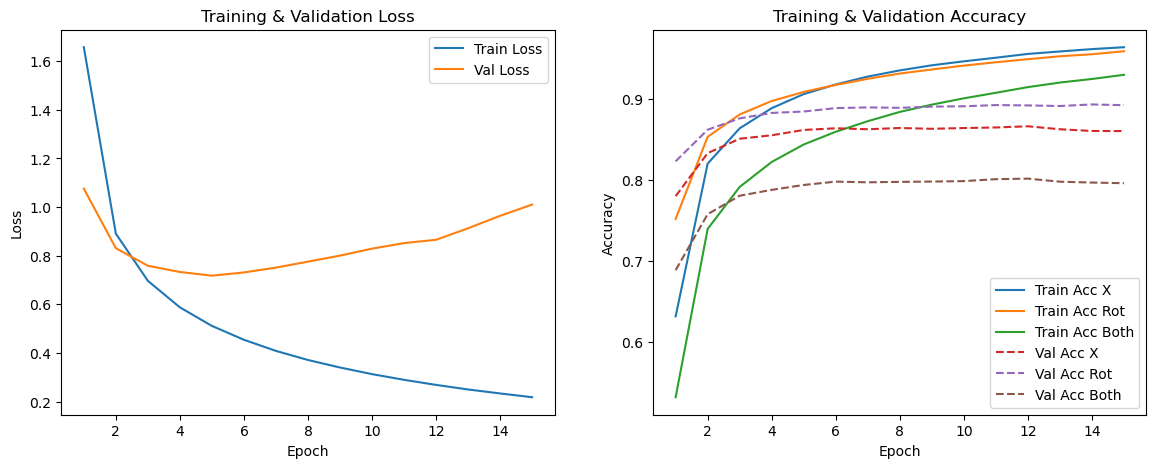

In [28]:
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(14, 5))

# loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()

# accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_acc_x_list, label="Train Acc X")
plt.plot(epochs_range, train_acc_rot_list, label="Train Acc Rot")
plt.plot(epochs_range, train_acc_both_list, label="Train Acc Both")
plt.plot(epochs_range, val_acc_x_list, label="Val Acc X", linestyle="--")
plt.plot(epochs_range, val_acc_rot_list, label="Val Acc Rot", linestyle="--")
plt.plot(epochs_range, val_acc_both_list, label="Val Acc Both", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training & Validation Accuracy")
plt.legend()

# f1

plt.show()

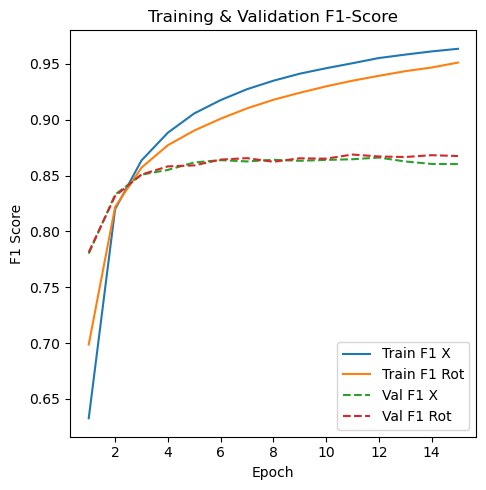

In [32]:
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_x_list, label="Train F1 X")
plt.plot(epochs_range, train_f1_rot_list, label="Train F1 Rot")

plt.plot(epochs_range, val_f1_x_list, label="Val F1 X", linestyle="--")
plt.plot(epochs_range, val_f1_rot_list, label="Val F1 Rot", linestyle="--")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.title("Training & Validation F1-Score")
plt.legend()

plt.tight_layout()
plt.show()

In [18]:
dataset = pd.read_csv(CSV_FILE)

num_duplicates = dataset.duplicated().sum()
print(f"Dublicates: {num_duplicates}")

total_rows = dataset.shape[0]
print(f"Total rows: {total_rows}")

Dublicates: 1178
Total rows: 817156


📝 Duplicate samples are minimal in this dataset (1,000 out of 800,000, or 0.125%) and therefore considered insignificant. They should have a negligible effect on the CNN’s learning or on overfitting.

## 🧪 Testing

📝 
* X position: 86.6% accuracy and F1 0.867 — this is very close, which means the model predicts the horizontal position of the piece quite well.
* Rotation: 89.3% accuracy and F1 0.871 — even higher, so the rotation is predicted even more accurately.
* Both correct: 80.3% — logically lower, because here the model needs to predict both the position and the rotation correctly; any mistake in either reduces this metric.
* F1 scores are close to the accuracy, which indicates that errors are distributed fairly evenly across classes — there is no strong bias toward any particular class.


In [37]:
# testing
print("\nTesting best model...")
model.load_state_dict(torch.load(SAVE_PATH))
model.eval()
test_correct_x, test_correct_rot, test_correct_both, test_samples = 0, 0, 0, 0
all_x_preds, all_x_targets = [], []
all_rot_preds, all_rot_targets = [], []

with torch.no_grad():
    for features, kind, targets in test_loader:
        features, kind = features.to(device), kind.to(device)
        rot_target, x_target = targets[:, 0].to(device), targets[:, 1].to(device)
        out_x, out_rot = model(features, kind)
        pred_x = out_x.argmax(1)
        pred_rot = out_rot.argmax(1)
        test_correct_x += (pred_x == x_target).sum().item()
        test_correct_rot += (pred_rot == rot_target).sum().item()
        test_correct_both += ((pred_x == x_target) & (pred_rot == rot_target)).sum().item()
        test_samples += x_target.size(0)

        #f1
        features, kind = features.to(device), kind.to(device)
        rot_target, x_target = targets[:, 0].to(device), targets[:, 1].to(device)

        out_x, out_rot = model(features, kind)
        pred_x = out_x.argmax(1)
        pred_rot = out_rot.argmax(1)

        all_x_preds.extend(pred_x.cpu().numpy())
        all_x_targets.extend(x_target.cpu().numpy())
        all_rot_preds.extend(pred_rot.cpu().numpy())
        all_rot_targets.extend(rot_target.cpu().numpy())

accuracy_x = test_correct_x / test_samples * 100
accuracy_rot = test_correct_rot / test_samples * 100
accuracy_both = test_correct_both / test_samples * 100
#acc
print(f"Test Accuracy (x position): {accuracy_x:.2f}%")
print(f"Test Accuracy (rotation): {accuracy_rot:.2f}%")
print(f"Test Accuracy (both correct): {accuracy_both:.2f}%")
#f1
test_f1_x = f1_score(all_x_targets, all_x_preds, average='macro')
test_f1_rot = f1_score(all_rot_targets, all_rot_preds, average='macro')

print(f"Test F1 X: {test_f1_x:.4f}, Test F1 Rot: {test_f1_rot:.4f}")



Testing best model...
Test Accuracy (x position): 86.64%
Test Accuracy (rotation): 89.33%
Test Accuracy (both correct): 80.29%
Test F1 X: 0.8667, Test F1 Rot: 0.8712


## Example of a not-so-bad game played by the bot

📝 Due to the lack of examples of “non-ideal moves,” the bot, despite having 80% accuracy, gets confused after making a single mistake. If the mistake isn’t critical, it can still find a more optimal move, but after several mistakes in a row, the bot makes moves that don’t resemble anything meaningful and can no longer find an optimal move, causing it to lose quickly.

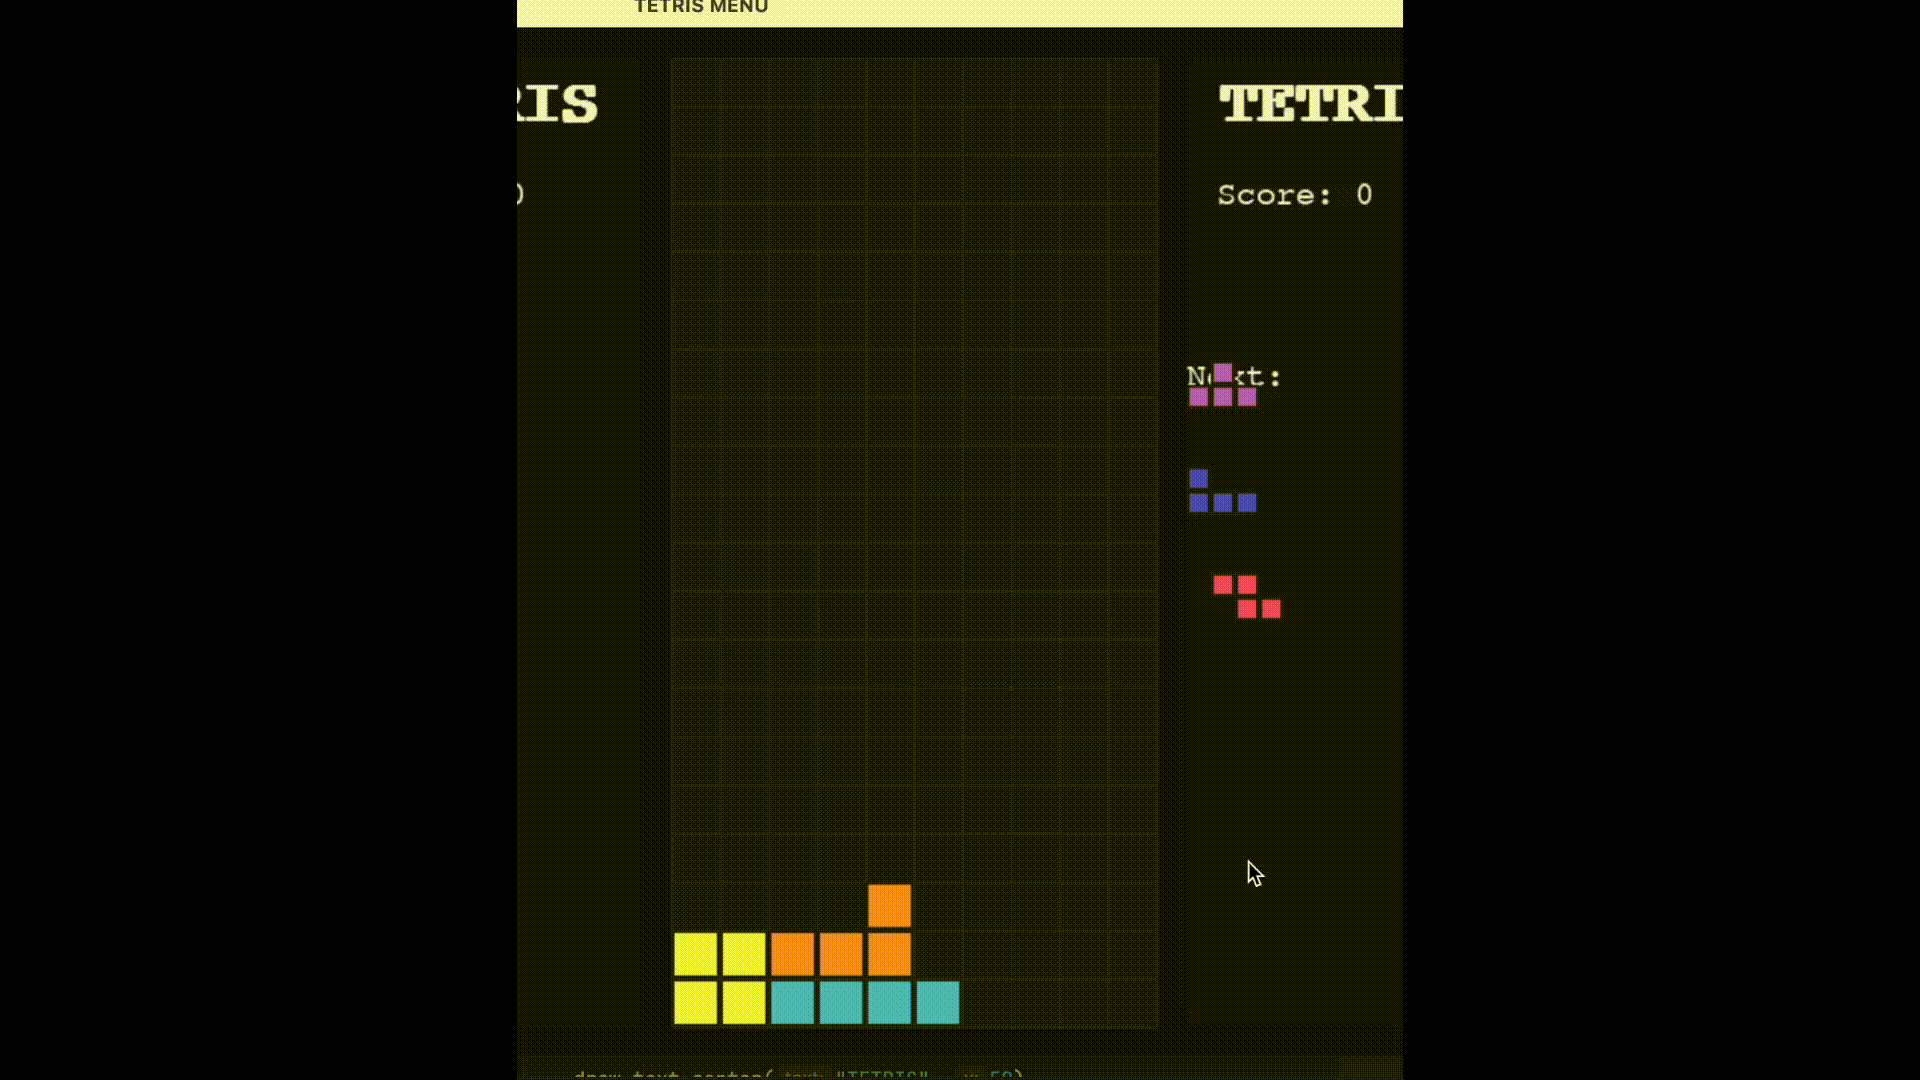